# Predictions

This notebook will use several prediction techniques and compare each to the other.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from utils.prepro import * 
import mapply
import multiprocessing as mp
from leap import *
from utils.fltrace_classes import *
from utils.constants import *
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from itertools import chain
from scipy import stats


mapply.init(
    n_workers=mp.cpu_count()-2,
    chunk_size=200,
    max_chunks_per_worker=8,
    progressbar=True
)
TESTING = False

# Data loading

In [ ]:
# Constants
if TESTING:
    _TEST_TRACE_BASE_PATH = "../data/data/parsec_raw_out/canneal/200_50/"
    TEST_FAULT_PATH = _TEST_TRACE_BASE_PATH+"fltrace-data-faults-58940-1.out"
    TEST_PROCMAP_PATH = _TEST_TRACE_BASE_PATH+"fltrace-data-procmaps-58940.out"
    runid = RunIdentifier("canneal",200,50,58940)

In [ ]:
if TESTING:
    df = pd.read_csv(TEST_FAULT_PATH)
    df.head()

In [ ]:
if TESTING:
    prepro_df,_,epci = preprocess_df(runid,df,Path(TEST_PROCMAP_PATH),get_stats=False,add_missing_ips_to_st=True)
    prepro_df.head()

In [ ]:
if TESTING:
    _, ndf = get_ip_not_in_st_stats(runid,prepro_df)

In [ ]:
if TESTING:
    ndf.head()

In [ ]:
if TESTING:
    df[ndf['flags'] < 32]

# Predict

## I. "Normal" leap 

In [ ]:
if TESTING:
    lc = LeapConfig("standard",10,10)
    res = get_leap(lc,ndf)

In [ ]:
if TESTING:
    res2 = get_leap(lc,ndf,enable_parallel=True)

In [ ]:
if TESTING:
    res

In [ ]:
if TESTING:
    res2

In [ ]:
if TESTING:
    lc2 = LeapConfig("per_path",10,10)
    res_per_path = get_leap(lc2,ndf,enable_parallel=True)

In [ ]:
if TESTING:
    lc3 = LeapConfig("per_pc",10,10)
    res_per_pc = get_leap(lc3,ndf,enable_parallel=True)

In [ ]:
if TESTING:
    total_len_rpp = sum(tpl._1 for tpl in res_per_path)
    total_len_rpi = sum(tpl._1 for tpl in res_per_pc)

# Clean, multiple results

In [3]:
PARENT_FOLDER_PATH = "../data/data/prediction_select_few/"
OBJDUMP_FOLDER_PATH = "../data/data/objdumps/"

In [ ]:
check_correct_dir(OBJDUMP_FOLDER_PATH)
LOAD_DATA = "all"

In [ ]:
check_correct_dir(PARENT_FOLDER_PATH)

#dict of the form: {RunIdentifier : ExtraProcessCodeInfo}
extra_info = defaultdict(ExtraProcessCodeInfo)

#dicts of the form: {RunIdentifier : pandas.DataFrame}
all_dfs = {}
fltrace_impact_stats = {} # df contains (initial_trace_length, number_impacted_ips, idx_first_ip, idx_last_ip, max_num_consecutive)

def check_correct_grandchildren(bench_name: str,path_to_grandchild: Path):
    check_correct_dir_str(path_to_grandchild)
    grand_child_errorstr_prefix = f"Grandchild {path_to_grandchild.absolute().as_posix()}"
    dir_name = path_to_grandchild.name
    assert "_" in dir_name, (grand_child_errorstr_prefix + "does not contain '_' in its name")
    m,l = splitted_name = dir_name.split(sep='_')
    assert len(splitted_name) == 2, (grand_child_errorstr_prefix + "contains more than 1 '_' in its name")
    assert splitted_name[0].isnumeric() and splitted_name[1].isnumeric(), ("The M/L values of "+ grand_child_errorstr_prefix + "are not numbers")
    
    pids_to_procmaps_path = {}
    
    for trace_output in sorted(path_to_grandchild.iterdir(),reverse=True):
        trace_output: Path = trace_output
        assert trace_output.is_file()
        fname = trace_output.stem
        assert len(fname) > 0
        if fname[0] == ".":
            # Ignore hidden files
            continue
        assert fname.startswith(FLTRACE_OUTPUT_PREFIX), f"{trace_output.absolute().as_posix()} is not correctly prefixed"
        assert trace_output.suffix == FLTRACE_OUTPUT_SUFFIX, f"{trace_output.absolute().as_posix()} is not correctly suffixed"
        splitted_fname = fname.split("-")
        pid = int(splitted_fname[-2 if "faults" in fname else -1])
        filetype = splitted_fname[2]
        if filetype == "stats":
            continue
        elif filetype == "procmaps":
            pids_to_procmaps_path[pid] = trace_output
        elif filetype == "faults":
            assert pid in pids_to_procmaps_path.keys(), f"Received faults before procmaps here {trace_output.as_posix()}: are procmaps missing?"
            procmap_path = pids_to_procmaps_path[pid]
            runid = RunIdentifier(bench_name,int(m),int(l),pid)
            if (LOAD_DATA == "all" or 
                    ("/" in LOAD_DATA and (len(all_dfs) == 0 and LOAD_DATA == f"{bench_name}/{m}_{l}")) or
                    ("/" not in LOAD_DATA and LOAD_DATA==bench_name)
                ) :
                df = pd.read_csv(trace_output.as_posix())
                print(f"Loaded data for {runid}. Starting preprocessing.")
                df,epci = single_preprocess(runid,df, procmap_path,use_ints=True)
                print(f"Finished preprocessing data for {runid}.")
                all_dfs[runid] = df
                extra_info[runid] = epci
        else:
            raise LookupError(f"While looking at {bench_name}, found the following file in one of the grandchildren which doesn't seem to be the output of fltrace: {trace_output.absolute().as_posix()}")
def check_correct_children(path_to_child: Path):
    check_correct_dir_str(path_to_child)
    benchmark_name = path_to_child.name
    for grandchild in path_to_child.iterdir():
        check_correct_grandchildren(benchmark_name,grandchild)
    print(f"All checks pass for {benchmark_name}.")

In [ ]:
for child in Path(PARENT_FOLDER_PATH).iterdir():
    check_correct_children(child)

In [ ]:
list(all_dfs.values())[0]["stacktrace"].unique()

In [ ]:
all_results = {}
K = 10
H = 10
for runid,df in all_dfs.items():
    lc = LeapConfig("standard",K,H)
    lc2 = LeapConfig("per_path",K,H)
    lc3 = LeapConfig("per_pc",K,H)
    res_std = get_leap(lc,df,enable_parallel=True)
    res_path = get_leap(lc2,df,enable_parallel=True)
    res_ip = get_leap(lc3,df,enable_parallel=True)
    all_results[runid] = {"std":res_std,"path":res_path,"ip":res_ip}

In [ ]:
import pickle 

with open('saved_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)


# Get graphs

In [4]:
def hot_patch_certainty(h,result_dict):
    for gr_res_dict in result_dict.values():
        for gr,res in gr_res_dict.items(): 
            if gr == "std":
                assert isinstance(res,tuple)
                # previously, crt = 100*count/len(histoy window)
                # But history window is actually of length = len(actual history) + 1
                # Where 1 is the last pfault
                # here, we fix this
                # note that we have average certs (sum(cert))/N --> can apply multiplicative factor everywhere
                new_crt = get_new_crt(h, res[0])
                new_tpl = tuple([new_crt,*res[1:]])
                gr_res_dict[gr] = new_tpl
            else:
                assert isinstance(res,list)
                new_list = []
                for res_tpl in res:
                    new_crt = get_new_crt(h,res_tpl[1])
                    new_list.append(tuple([res_tpl[0],new_crt,*res_tpl[2:]]))
                gr_res_dict[gr] = new_list
def get_new_crt(h, current_cert):
    return (current_cert*h)/(h-1)

In [5]:
with open("full_other_h_res.pkl","rb") as f:
    other_res = pickle.load(f)
with open("saved_results.pkl","rb") as f:
    ten_res = pickle.load(f)
with open("next_other_h_res.pkl","rb") as f:
    other_other_res = pickle.load(f)
full_data = {}
full_data.update(other_res)
full_data.update(other_other_res)
full_data[10] = ten_res
all_results = ten_res

for h,res_dict in full_data.items():
    hot_patch_certainty(h,res_dict)

In [6]:
run_types = set()
for benchmark in all_results.values():
    # Just in case we're missing some run types in one of the runs
    run_types.update(benchmark.keys())
run_types = sorted(list(run_types))[::-1]
benchmarks = list(all_results.keys())
benchmark_labels = list([rid.program_name for rid in benchmarks])

# ! Order matters
METRICS = ['Certainty', 'Success', 'Precision']
  

## 1. Metric per benchmark

In [11]:
def compute_weighted_average(results_with_n):
    #results_with_n: List of (N, certainty, succes, recall, num_predictions) tuples
    # Performs weighted average of all metrics 
    # returns [weighted_avg_certainty, weighted_avg_success, weighted_avg_recall]
    if isinstance(results_with_n,list):
        results_with_n = np.array(results_with_n)
    results_with_n = results_with_n[:,1:] # Discard the group size (first columns)
    sizes = results_with_n[:,-1]
    total_size = np.sum(sizes)
    weighted_sums = [0, 0, 0]  # One for each metric
    

    for i in range(len(weighted_sums)): 
        weighted_sums[i] = np.sum(results_with_n[:,i]*sizes)/total_size
    return weighted_sums

def get_metric_aggregate_value(all_results_dict, benchmark, run_type, metric_idx):
    results = all_results_dict[benchmark][run_type]
    if run_type in ["path", "ip"]:
        # Weighted average of each group's values
        weighted_avgs = compute_weighted_average(results)
        return weighted_avgs[metric_idx]
    else:
        return results[metric_idx]



def plot_per_benchmark_results(results_dict: dict[RunIdentifier,dict[str,tuple|list]]):
    ## `results_dict` is of the type  {<runid>:<results>}
    ## `results` is of the type {<grouping string>:<group_run_results>}
    ## group_run_results is either a 
    ##              * 4-tuple (average certainty,average success, average recall, N_predictions)
    ##              * a list of several such 4-tuples (if grouping is per_path or per_pc)  
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 6, height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 1:5])  # Spans both columns in first row
    ax2 = fig.add_subplot(gs[1, 0:3])  # First plot in second row
    ax3 = fig.add_subplot(gs[1, 3:])  # Second plot in second row
    
    fig.suptitle('Benchmark Results by Metric', fontsize=16)
    bar_width = 1.65 / len(run_types)
    x = np.arange(2*len(benchmark_labels))
    colors = plt.cm.Set3(np.linspace(0, 1, len(run_types)))
    
    # Create bars for each metric
    for i, grouping_type in enumerate(run_types):
        ceretainty_vals = [get_metric_aggregate_value(results_dict, b, grouping_type, 0)/100 for b in benchmarks]
        success_vals    = [get_metric_aggregate_value(results_dict, b, grouping_type, 1) for b in benchmarks]
        recall_vals     = [get_metric_aggregate_value(results_dict, b, grouping_type, 2) for b in benchmarks]
        
        # Position for this set of bars (thanks Chat)
        pos = x[::2] + i * bar_width #- (len(run_types) * bar_width)/2
        rt_name = grouping_type if grouping_type!="std" else "none"
        rt_name = "PC" if rt_name == "ip" else( "stacktrace" if rt_name == "path" else rt_name)
        y_formatter = lambda y : (f'{y:.3f}'if isinstance(y,float) or isinstance(y,np.floating) else str(y))+('\n' if i%2 != 0 else '')
        r1 = ax1.bar(pos, ceretainty_vals, bar_width, label=rt_name, color=colors[i])
        fs = 8
        ax1.bar_label(r1,labels=[f'{y_formatter(y_value)}' for y_value in ceretainty_vals],fontsize=fs)
        r2 = ax2.bar(pos, success_vals, bar_width, label=rt_name, color=colors[i])
        ax2.bar_label(r2,labels=[f'{y_formatter(y_value)}' for y_value in success_vals],fontsize=fs)
        r3 = ax3.bar(pos, recall_vals, bar_width, label=rt_name, color=colors[i])
        ax3.bar_label(r3,labels=[f'{y_formatter(y_value)}' for y_value in recall_vals],fontsize=fs)
    
    for ax, metric in zip([ax1, ax2, ax3], METRICS):
        ax.set_ylabel(f'{metric} Score')
        ax.set_xticks(x[::2]+bar_width,benchmark_labels,rotation=30)
        ax.grid(True, axis='y', linestyle='--', alpha=0.6)
        ax.legend(title='Grouping')
        ax.set_title(f'Average {metric} Results')
        ax.set_ylim([0,1.1])


    plt.tight_layout()
    return fig


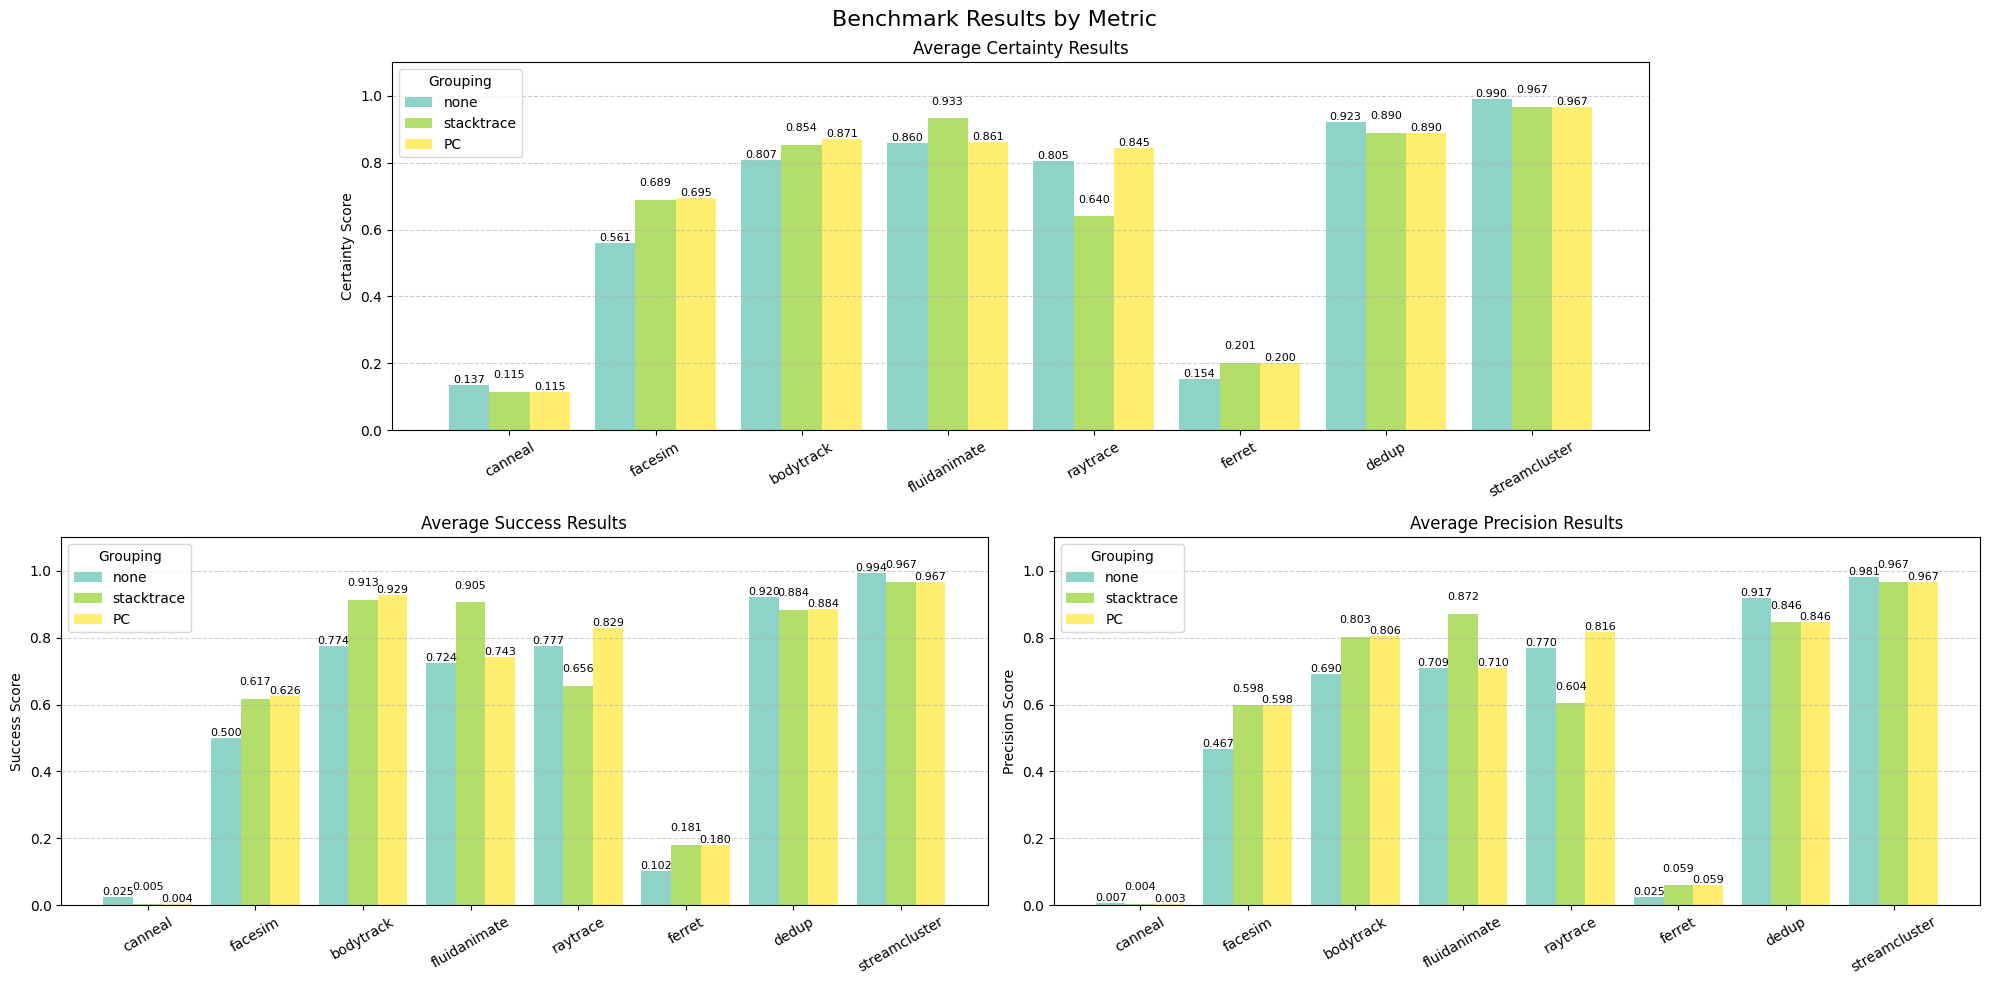

In [12]:
fig = plot_per_benchmark_results(all_results)
fig.savefig("out_figs/brm.pdf")

In [54]:
def find_first_runid_from_name(all_runids:Sequence[RunIdentifier],name):
    for rid in all_runids:
        if rid.program_name == name:
            return rid
    raise KeyError()

In [9]:
all_results[find_first_runid_from_name(all_results.keys(),"canneal")]

{'std': (13.664386512503604,
  0.024839195378973458,
  0.006596649465856112,
  11038240),
 'path': [(163, 11.11111111111111, 0.0, 0.0, 144),
  (704783,
   11.136856530066172,
   3.5472867513096584e-05,
   3.8310696914144325e-05,
   704764),
  (60974,
   11.134443441883358,
   9.843327044541054e-05,
   5.085718973012881e-05,
   60955),
  (34, 11.11111111111111, 0.0, 0.0, 15),
  (12086, 100.0, 1.0, 1.0, 12067),
  (23, 11.11111111111111, 0.0, 0.0, 4),
  (316060,
   11.14440496292851,
   4.4298049936558864e-05,
   6.201726991118242e-05,
   316041),
  (364235,
   11.14152651784167,
   6.864058690447427e-05,
   5.189228369978257e-05,
   364216),
  (996, 11.11111111111111, 0.0, 0.0001023541453428864, 977),
  (1302350,
   11.14063082955784,
   4.991050662235637e-05,
   5.4364059520966663e-05,
   1302331),
  (383, 11.11111111111111, 0.0, 0.0, 364),
  (1358857,
   11.140924165434814,
   5.1514602918081476e-05,
   5.3428002455038814e-05,
   1358838),
  (31, 100.0, 1.0, 0.09999999999999999, 12),
 

In [10]:
all_results

{RunIdentifier(program_name='canneal', m=200, l=50, pid=58940): {'std': (13.664386512503604,
   0.024839195378973458,
   0.006596649465856112,
   11038240),
  'path': [(163, 11.11111111111111, 0.0, 0.0, 144),
   (704783,
    11.136856530066172,
    3.5472867513096584e-05,
    3.8310696914144325e-05,
    704764),
   (60974,
    11.134443441883358,
    9.843327044541054e-05,
    5.085718973012881e-05,
    60955),
   (34, 11.11111111111111, 0.0, 0.0, 15),
   (12086, 100.0, 1.0, 1.0, 12067),
   (23, 11.11111111111111, 0.0, 0.0, 4),
   (316060,
    11.14440496292851,
    4.4298049936558864e-05,
    6.201726991118242e-05,
    316041),
   (364235,
    11.14152651784167,
    6.864058690447427e-05,
    5.189228369978257e-05,
    364216),
   (996, 11.11111111111111, 0.0, 0.0001023541453428864, 977),
   (1302350,
    11.14063082955784,
    4.991050662235637e-05,
    5.4364059520966663e-05,
    1302331),
   (383, 11.11111111111111, 0.0, 0.0, 364),
   (1358857,
    11.140924165434814,
    5.1514602

In [24]:
def get_size_scatters(all_results_dict:dict[RunIdentifier,dict]):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Differences from weighted means', fontsize=16)
    colors = plt.cm.Set2(np.linspace(0, 1, len(benchmarks)))#["#ef476f","#f78c6b","#ffd166","#83d483","#06d6a0","#0cb0a9","#118ab2","#073b4c"] if len(benchmarks) == 8 else 

    hndl,lbl = [],[] # For the figure axes afterwards, only populated once
    mixl,maxl = 100000000000,0
    for grouping_idx, grouping_type in enumerate(['path', 'ip']):
        for metric_idx, metric_name in enumerate(METRICS):
            ax = axes[grouping_idx][metric_idx]
            for color, (benchmark, benchmark_data) in zip(colors, all_results_dict.items()):
                group_sizes = np.array([tuple_info[0] for tuple_info in benchmark_data[grouping_type]])
                actual_predicted = np.array([tuple_info[-1] for tuple_info in benchmark_data[grouping_type]])
                good_idcs = group_sizes != actual_predicted
                raw_metric_values = np.array([tuple_info[1+metric_idx] for tuple_info in benchmark_data[grouping_type]])[good_idcs]
                weighted_metric_values = get_metric_aggregate_value(all_results_dict,benchmark,grouping_type,metric_idx)
                difference_from_weighted = raw_metric_values-weighted_metric_values
                if metric_idx == 0:
                    difference_from_weighted/=100
                
                h= ax.scatter(group_sizes[good_idcs], difference_from_weighted, 
                            label=benchmark, 
                            color=color, 
                            alpha=0.7,
                            marker='.')
                if grouping_idx == 0 and metric_idx == 0:
                        hndl.append(h)
                        lbl.append(benchmark.program_name)
            

            ax.set_xscale('log')
            ax.set_xlabel('Size of the group (log scale)')
            ax.set_ylabel(f'Difference from (weighted) average')
            ax.set_title(f'{ "PC" if grouping_type == "ip" else( "stacktrace" if grouping_type == "path" else grouping_type)} grouping - {metric_name}')
            ax.grid(True, which="both", ls="-", alpha=0.2)
            #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')lims = ax.get_xlim()
            lims=ax.get_xlim()
            mixl = min(mixl,lims[0])
            maxl = max(maxl,lims[1])

    for ax in axes.flatten():
        ax.set_xlim([mixl,maxl])
        ax.set_ylim([-1,1.1])

    fig.legend(hndl, lbl, loc='upper center', ncol=len(hndl), bbox_to_anchor=(0.5, 0), title='Benchmarks')
    plt.tight_layout(rect=[0, 0.04, 1, 0.95])  # Make room for legends
    return fig

In [136]:
from matplotlib.patches import PathPatch
def get_size_hexbins(all_results_dict: dict[RunIdentifier, dict]):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Differences from weighted means', fontsize=16)
    colors = ["#ef476f","#f78c6b","#ffd166","#83d483","#06d6a0","#0cb0a9","#118ab2","#073b4c"] if len(benchmarks) == 8 else plt.cm.Set3(np.linspace(0, 1, len(benchmarks)))
    
    hndl, lbl = [], []  # For the figure axes afterwards, only populated once
    
    mixl,maxl = 100000000000,0

    for run_type_idx, grouping_type in enumerate(['path', 'ip']):
        for metric_idx, metric_name in enumerate(METRICS):
            ax = axes[run_type_idx][metric_idx]
            
            for color, (benchmark, benchmark_data) in zip(colors, all_results_dict.items()):
                group_sizes = np.array([tuple_info[0] for tuple_info in benchmark_data[grouping_type]])
                actual_predicted = np.array([tuple_info[-1] for tuple_info in benchmark_data[grouping_type]])
                good_idcs = group_sizes != actual_predicted
                raw_metric_values = np.array([tuple_info[1+metric_idx] for tuple_info in benchmark_data[grouping_type]])[good_idcs]
                weighted_metric_values = get_metric_aggregate_value(all_results_dict, benchmark, grouping_type, metric_idx)
                difference_from_weighted = raw_metric_values-weighted_metric_values
                if metric_idx == 0:
                    difference_from_weighted /= 100
                
                # Create hexbin plot for this benchmark with its specific color
                if len(group_sizes[good_idcs]) > 0:
                    hb = ax.hexbin(group_sizes[good_idcs], 
                                 difference_from_weighted,
                                 gridsize=20,      # Adjust this value to control hex density
                                 xscale='log',     # Keep log scale for x-axis
                                 bins='log',       # Use log binning for color scale
                                 cmap=plt.cm.get_cmap('Greys_r').copy(),  # Use grayscale for opacity
                                 mincnt=1,         # Minimum number of points for a hex to be colored
                                 alpha=1.0)        # Start with full opacity
                    
                    # Get the hex paths and counts
                    paths = hb.get_paths()
                    counts = hb.get_array()
                    
                    # Remove the original hexbin
                    hb.remove()
                    
                    # Normalize counts to [0.2, 1.0] range for alpha
                    if counts.size > 0:  # Check if we have any counts
                        alphas = 0.2 + 0.8 * (counts - counts.min()) / (counts.max() - counts.min() if counts.max() != counts.min() else 1)
                    else:
                        alphas = []
                    
                    # Create collection of colored hexagons with varying alpha
                    for path, alpha in zip(paths, alphas):
                        patch = PathPatch(path, facecolor=color, alpha=round(alpha,3), edgecolor='none')
                        ax.add_patch(patch)
                
                # Add to legend
                if run_type_idx == 0 and metric_idx == 0:
                    h = ax.scatter([], [], label=benchmark, color=color, alpha=0.7)
                    hndl.append(h)
                    lbl.append(benchmark.program_name)
            
            ax.set_xscale('log')
            ax.set_xlabel('Size of the group (log scale)')
            ax.set_ylabel(f'Difference from (weighted) average')
            ax.set_title(f'{grouping_type} grouping - {metric_name}')
            ax.grid(True, which="both", ls="-", alpha=0.2)
            lims = ax.get_xlim()
            mixl = min(mixl,lims[0])
            maxl = max(maxl,lims[1])

    for ax in axes.flatten():
        ax.set_xlim([mixl,maxl])
        ax.set_ylim([-1,1.1])

    fig.legend(hndl, lbl, loc='upper center', ncol=len(hndl), bbox_to_anchor=(0.5, 0), title='Benchmarks')
    
    plt.tight_layout(rect=[0, 0.04, 1, 0.95])  # Make room for legends
    return fig

In [25]:
f = get_size_hexbins(all_results)
f.savefig("out_figs/dwm_hb.png",bbox_inches='tight')

NameError: name 'get_size_hexbins' is not defined

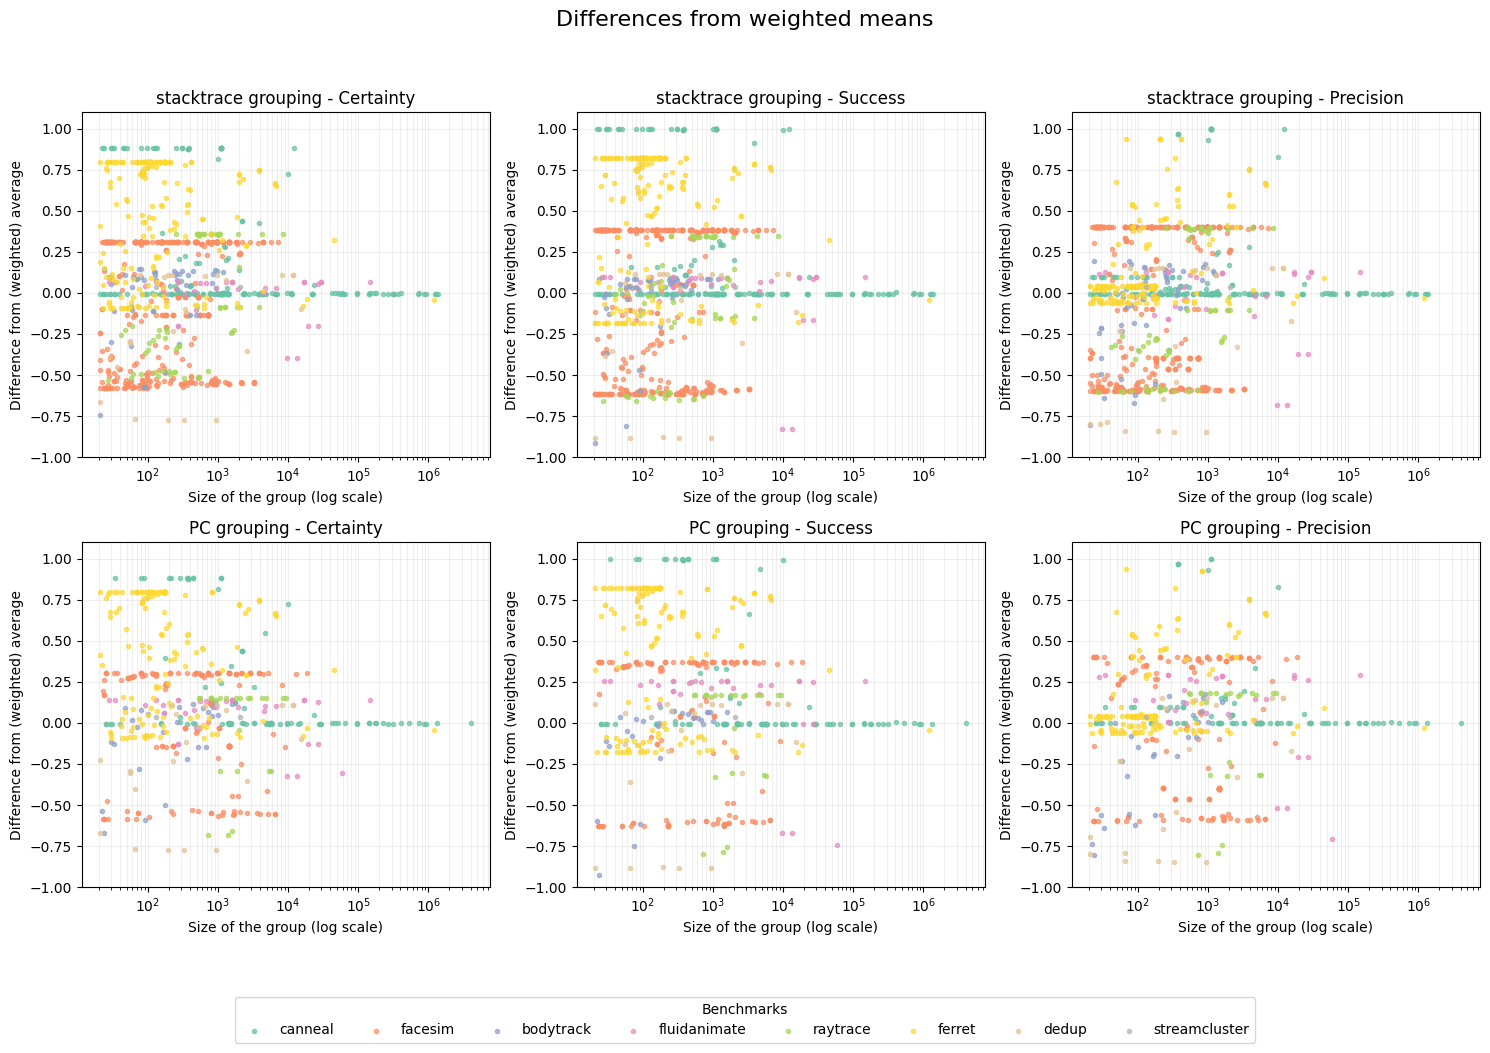

In [26]:
f = get_size_scatters(all_results)
f.savefig("out_figs/dwm_sc.pdf",bbox_inches='tight')

In [141]:
def analyze_size_metric_correlations(all_results_dict: dict[RunIdentifier, dict]):
    """
    Analyze correlations between group sizes and metrics using t-tests.
    Prints results with interpretations for each benchmark, run type, and metric combination.
    """
    from scipy import stats
    import pandas as pd
    
    results = []
    
    def interpret_correlation(correlation, p_value, n_samples):
        """Helper function to generate interpretation text"""
        # Interpret strength
        if abs(correlation) > 0.7:
            strength = "strong"
        elif abs(correlation) > 0.5:
            strength = "moderate"
        elif abs(correlation) > 0.3:
            strength = "weak"
        else:
            strength = "very weak"
            
        # Interpret direction
        direction = "positive" if correlation > 0 else "negative"
        
        # Interpret significance
        if p_value < 0.001:
            significance = "highly significant"
        elif p_value < 0.01:
            significance = "very significant"
        elif p_value < 0.05:
            significance = "significant"
        else:
            significance = "not statistically significant"
            
        # Sample size adequacy
        sample_size_note = ""
        if n_samples < 30:
            sample_size_note = " However, the sample size is relatively small, so results should be interpreted with caution."
        
        # Practical interpretation
        if correlation > 0:
            practical = "As group size increases, the metric tends to increase relative to the weighted mean."
        else:
            practical = "As group size increases, the metric tends to decrease relative to the weighted mean."
            
        if p_value >= 0.05:
            practical = "There is no clear evidence of a relationship between group size and this metric."
            
        return (f"There is a {strength} {direction} correlation (r={correlation:.3f}) that is {significance} "
                f"(p={p_value:.3e}).{sample_size_note}\n{practical}")

    for run_type in ['path', 'ip']:
        print(f"\n{'='*20} {run_type.upper()} {'='*20}")
        
        for benchmark, benchmark_data in all_results_dict.items():
            print(f"\n{'-'*50}")
            print(f"Benchmark: {benchmark.program_name}")
            print(f"{'-'*50}")
            
            # Get group sizes
            group_sizes = np.array([tuple_info[0] for tuple_info in benchmark_data[run_type]])
            actual_predicted = np.array([tuple_info[-1] for tuple_info in benchmark_data[run_type]])
            good_idcs = group_sizes != actual_predicted
            group_sizes = group_sizes[good_idcs]
            
            # Log transform the group sizes
            log_sizes = np.log10(group_sizes)
            
            for metric_idx, metric_name in enumerate(METRICS):
                raw_metric_values = np.array([tuple_info[1+metric_idx] 
                                           for tuple_info in benchmark_data[run_type]])[good_idcs]
                
                weighted_metric_values = get_metric_aggregate_value(all_results_dict,
                                                                 benchmark,
                                                                 run_type,
                                                                 metric_idx)
                
                difference_from_weighted = raw_metric_values - weighted_metric_values
                if metric_idx == 0:
                    difference_from_weighted /= 100
                
                # Calculate statistics
                correlation, p_value = stats.pearsonr(log_sizes, difference_from_weighted)
                n_samples = len(log_sizes)
                t_statistic = correlation * np.sqrt((n_samples-2)/(1-correlation**2))
                
                # Effect size interpretation (R-squared)
                r_squared = correlation ** 2
                
                results.append({
                    'Run Type': run_type,
                    'Benchmark': benchmark.program_name,
                    'Metric': metric_name,
                    'Correlation': correlation,
                    'R-squared': r_squared,
                    'P-value': p_value,
                    't-statistic': t_statistic,
                    'N': n_samples
                })
                
                print(f"\n{metric_name}:")
                print(f"Statistical Results:")
                print(f"  • Correlation coefficient: {correlation:.3f}")
                print(f"  • R-squared: {r_squared:.3f} ({r_squared*100:.1f}% of variance explained)")
                print(f"  • t-statistic: {t_statistic:.3f}")
                print(f"  • p-value: {p_value:.3e}")
                print(f"  • Sample size: {n_samples}")
                
                # Add significance stars
                if p_value < 0.001:
                    print("  • Significance: ***")
                elif p_value < 0.01:
                    print("  • Significance: **")
                elif p_value < 0.05:
                    print("  • Significance: *")
                
                print("\nInterpretation:")
                print(interpret_correlation(correlation, p_value, n_samples))
    
    # Create and sort summary DataFrame
    df_results = pd.DataFrame(results)
    df_results['Abs_Correlation'] = df_results['Correlation'].abs()
    df_results = df_results.sort_values('Abs_Correlation', ascending=False)
    df_results = df_results.drop('Abs_Correlation', axis=1)
    
    print("\n" + "="*80)
    print("SUMMARY OF FINDINGS")
    print("="*80)
    
    # Print top 3 strongest correlations
    print("\nStrongest relationships found:")
    top_3 = df_results.head(3)
    for _, row in top_3.iterrows():
        print(f"\n{row['Benchmark']} - {row['Metric']} ({row['Run Type']})")
        print(interpret_correlation(row['Correlation'], row['P-value'], row['N']))
    
    # Print overall summary statistics
    print("\nOverall Summary:")
    print(f"• Total number of significant correlations: {len(df_results[df_results['P-value'] < 0.05])}")
    print(f"• Strongest correlation: {df_results['Correlation'].abs().max():.3f}")
    print(f"• Median absolute correlation: {df_results['Correlation'].abs().median():.3f}")
    
    # pd.set_option('display.max_rows', None)
    # pd.set_option('display.float_format', lambda x: '%.3f' % x)
    # print("\nDetailed Results:")
    # print(df_results)
    
    return df_results

In [16]:
correlation_results = analyze_size_metric_correlations(all_results)


==================== PATH ====================

--------------------------------------------------
Benchmark: canneal
--------------------------------------------------

Certainty:
Statistical Results:
  • Correlation coefficient: -0.325
  • R-squared: 0.106 (10.6% of variance explained)
  • t-statistic: -4.537
  • p-value: 1.062e-05
  • Sample size: 176
  • Significance: ***

Interpretation:
There is a weak negative correlation (r=-0.325) that is highly significant (p=1.062e-05).
As group size increases, the metric tends to decrease relative to the weighted mean.

Success:
Statistical Results:
  • Correlation coefficient: -0.317
  • R-squared: 0.100 (10.0% of variance explained)
  • t-statistic: -4.408
  • p-value: 1.824e-05
  • Sample size: 176
  • Significance: ***

Interpretation:
There is a weak negative correlation (r=-0.317) that is highly significant (p=1.824e-05).
As group size increases, the metric tends to decrease relative to the weighted mean.

Recall:
Statistical Results

/tmp/ipykernel_616472/1347641846.py:84: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = stats.pearsonr(log_sizes, difference_from_weighted)


In [17]:
def display_top_correlations(df_results: pd.DataFrame, n_results: int = 6):
    """
    Display the most interesting correlation results in a formatted table.
    Interesting is defined as a combination of correlation strength and statistical significance.
    """
    from prettytable import PrettyTable
    
    # Create interest score (combination of absolute correlation and statistical significance)
    df_results = df_results.copy()
    df_results['interest_score'] = df_results['Correlation'].abs() * (-np.log10(df_results['P-value']))
    
    # Sort by interest score
    top_results = df_results.nlargest(n_results, 'interest_score')
    
    # Create and configure table
    table = PrettyTable()
    table.field_names = ["Benchmark", "Run Type", "Metric", "Correlation", "P-value", "Interpretation"]
    table.align = "l"  # Left align text
    table.max_width = 50  # Maximum width for each column
    
    def get_interpretation(row):
        """Generate concise interpretation text"""
        # Determine strength
        corr = row['Correlation']
        abs_corr = abs(corr)
        if abs_corr > 0.7:
            strength = "Strong"
        elif abs_corr > 0.5:
            strength = "Moderate"
        elif abs_corr > 0.3:
            strength = "Weak"
        else:
            strength = "Very weak"
            
        # Direction
        direction = "positive" if corr > 0 else "negative"
        
        # Significance stars
        if row['P-value'] < 0.001:
            sig = "***"
        elif row['P-value'] < 0.01:
            sig = "**"
        elif row['P-value'] < 0.05:
            sig = "*"
        else:
            sig = ""
            
        # Practical meaning
        if corr > 0:
            practical = "Metric increases with group size"
        else:
            practical = "Metric decreases with group size"
            
        if row['P-value'] >= 0.05:
            practical = "No clear relationship with size"
            
        return f"{strength} {direction} correlation{sig}\n{practical}\nR² = {row['R-squared']:.2f}"
    
    # Add rows to table
    for _, row in top_results.iterrows():
        table.add_row([
            row['Benchmark'],
            row['Run Type'],
            row['Metric'],
            f"{row['Correlation']:.3f}",
            f"{row['P-value']:.2e}",
            get_interpretation(row)
        ])
    
    # Print table with title
    print("\nMost Interesting Size-Metric Correlations")
    print("* p<0.05, ** p<0.01, *** p<0.001")
    print(table)
    
    return table

In [18]:
table = display_top_correlations(correlation_results)


Most Interesting Size-Metric Correlations
* p<0.05, ** p<0.01, *** p<0.001
+-----------+----------+-----------+-------------+----------+----------------------------------+
| Benchmark | Run Type | Metric    | Correlation | P-value  | Interpretation                   |
+-----------+----------+-----------+-------------+----------+----------------------------------+
| bodytrack | ip       | Recall    | 0.793       | 8.17e-07 | Strong positive correlation***   |
|           |          |           |             |          | Metric increases with group size |
|           |          |           |             |          | R² = 0.63                        |
| raytrace  | path     | Certainty | 0.594       | 2.25e-07 | Moderate positive correlation*** |
|           |          |           |             |          | Metric increases with group size |
|           |          |           |             |          | R² = 0.35                        |
| raytrace  | path     | Recall    | 0.588       | 

# Extend results

In [19]:
H_INTEREST = [2,5,10,50,100]

In [18]:
@dataclass
class LeapResult:
    certainty: float
    success: float
    recall: float
    num_preds: float
    def __post_init__(self):
        self.certainty = self.certainty/100

    def __repr__(self):
        return f"C,S,R: {self.certainty:.2f},{self.success:.2f},{self.recall:.2f}"

    def __add__(self,other):
        if isinstance(other,LeapResult):
            other = np.array(other.to_tuple())
        return LeapResult(*(np.array(self.to_tuple())+other).tolist())
        
    def __mul__(self,other):
        if isinstance(other,LeapResult):
            other = np.array(other.to_tuple())
        return LeapResult(*(np.array(self.to_tuple())*other).tolist())

    def __truediv__(self,other):
        if isinstance(other,LeapResult):
            other = np.array(other.to_tuple())
        return LeapResult(*(np.array(self.to_tuple())/other).tolist())
        
    def to_tuple(self,crt_as_pct=False):
        return ((100 if crt_as_pct else 1) * self.certainty,self.success,self.recall,self.num_preds)

@dataclass
class MultiLR:
    all_results:list

    def __post_init__(self):
        assert len(self.all_results) > 0
        if isinstance(self.all_results[0],tuple):
            # N, LR
            self.all_results = [(tpl[0],LeapResult(*tpl[1:])) for tpl in self.all_results]
        else:
            raise ValueError
    def __repr__(self):
        return str(self.all_results)
    def get_weighted(self):
        return LeapResult(*compute_weighted_average(np.array([(lr[0],*(lr[1].to_tuple(crt_as_pct=True))) for lr in self.all_results])),num_preds=sum(tpl[1].num_preds for tpl in self.all_results))

In [19]:
df = pd.DataFrame.from_dict({(h, runid.program_name): full_data[h][runid] 
                              for h in full_data.keys() 
                              for runid in full_data[h].keys()}, 
                             orient='index')
df.index.names = ['H','bench_name']

to_lr = lambda tpl: LeapResult(*tpl)
df["std"] = df["std"].apply(to_lr)
df = df.rename(columns={"std":"none"})
df["ip"] = df["ip"].apply(MultiLR)
df["path"] = df["path"].apply(MultiLR)
df = df.sort_index(level=0)


In [22]:
df.index

MultiIndex([(  2,     'bodytrack'),
            (  2,       'canneal'),
            (  2,         'dedup'),
            (  2,       'facesim'),
            (  2,        'ferret'),
            (  2,  'fluidanimate'),
            (  2,      'raytrace'),
            (  2, 'streamcluster'),
            (  5,     'bodytrack'),
            (  5,       'canneal'),
            (  5,         'dedup'),
            (  5,       'facesim'),
            (  5,        'ferret'),
            (  5,  'fluidanimate'),
            (  5,      'raytrace'),
            (  5, 'streamcluster'),
            ( 10,     'bodytrack'),
            ( 10,       'canneal'),
            ( 10,         'dedup'),
            ( 10,       'facesim'),
            ( 10,        'ferret'),
            ( 10,  'fluidanimate'),
            ( 10,      'raytrace'),
            ( 10, 'streamcluster'),
            ( 25,     'bodytrack'),
            ( 25,       'canneal'),
            ( 25,         'dedup'),
            ( 25,       'fac

In [27]:

def create_multi_metric_plot(df):
    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    fig.suptitle('Impact of H when prefetching with Leap using different groupings', fontsize=16)
    
    markers = ['o', '^', 's']  # circle, triangle, square
    
    bench_names = df.index.get_level_values('bench_name').unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(bench_names)))
    
    metrics = ['certainty', 'success', 'precision']
    marker_handles = [
        mlines.Line2D([], [], color='gray', marker=marker, linestyle='None',
                      markersize=10, label="PC" if col == "ip" else( "stacktrace" if col == "path" else col)) 
        for marker, col in zip(markers, df.columns)
    ]
    
    color_handles = [
        mpatches.Patch(color=color, label=bench_name) 
        for color, bench_name in zip(colors, bench_names)
    ]
    
    for metric_idx, metric in enumerate(metrics):
        ax = axes[metric_idx]
        ax.set_title(f'Average {metric}')
        ax.set_xlabel('H')
        ax.set_ylabel(f'{metric}')
        
        for bench_idx, bench_name in enumerate(bench_names):
            for column, marker in zip(df.columns, markers):
                bench_data = df.loc[pd.IndexSlice[:, bench_name], column]
                
                h_values = bench_data.index.get_level_values('H')
                
                # Prepare all metric values although we will only be needing one 
                # (for debugging lol)
                metric_values = {
                    'certainty': [getattr(result, 'get_weighted')().certainty if hasattr(result, 'get_weighted') else result.certainty for result in bench_data],
                    'precision': [getattr(result, 'get_weighted')().recall if hasattr(result, 'get_weighted') else result.recall for result in bench_data],
                    'success': [getattr(result, 'get_weighted')().success if hasattr(result, 'get_weighted') else result.success for result in bench_data]
                }
                
                ax.plot(h_values, metric_values[metric], 
                        color=colors[bench_idx], 
                        marker=marker,
                        linestyle='-',
                        alpha=0.7)
        
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add legends
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Make room for legends
    
    # Create two separate legends
    fig.legend(handles=marker_handles, 
               title='Grouping', 
               loc='lower left', 
               bbox_to_anchor=(0, 0), 
               ncol=len(df.columns))
    
    fig.legend(handles=color_handles, 
               title='Benchmark', 
               loc='lower right', 
               bbox_to_anchor=(0.9, 0), 
               ncol=len(bench_names))
    
    return fig

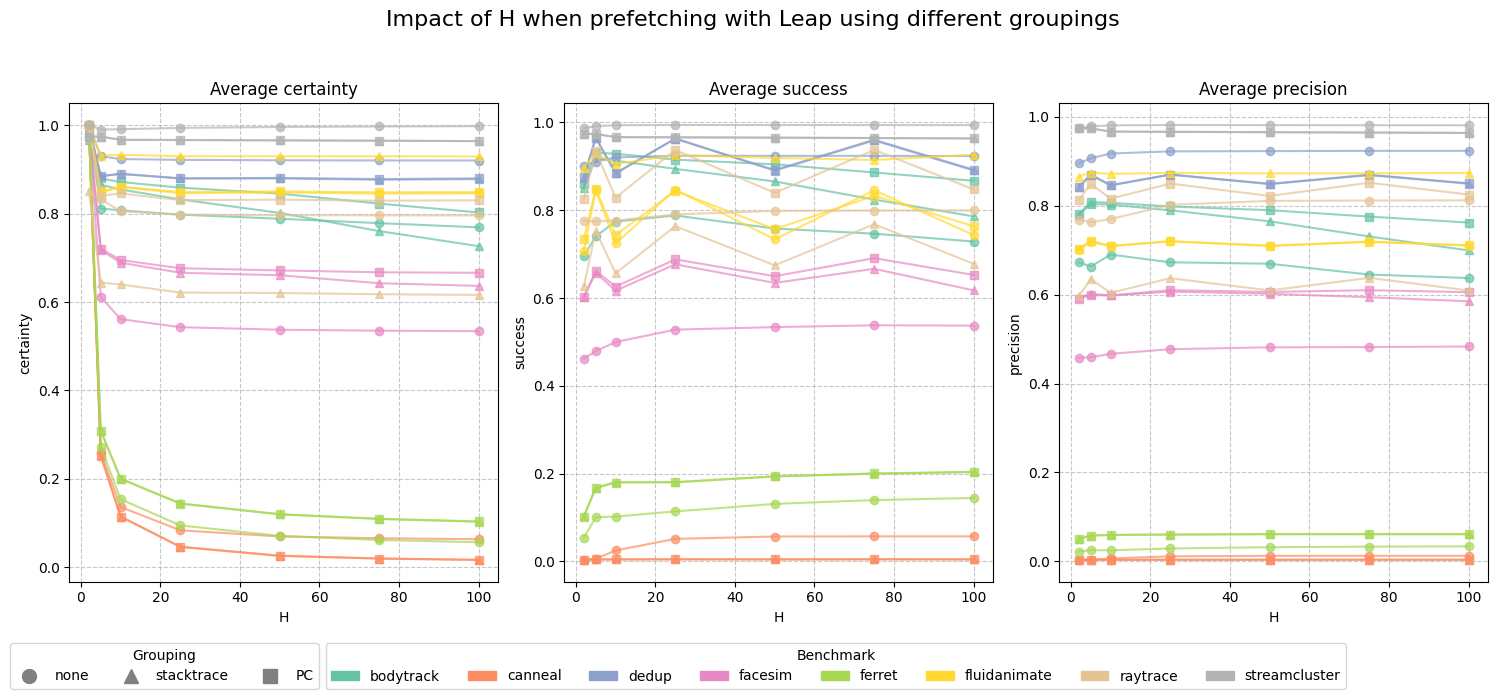

In [28]:
f = create_multi_metric_plot(df)
f.savefig("out_figs/ih.pdf")

In [151]:
a = sorted([(res[1],res[1].num_preds) for res in df.loc[10,"canneal"]["path"].all_results if res[1].certainty > 0.7],key=lambda tpl:tpl[-1],reverse=True)
print(len(a),sum([tpl[-1] for tpl in a]),"\n",a)

30 33478 
 [(C,S,R: 1.00,1.00,1.00, 12067), (C,S,R: 0.84,0.99,0.83, 10016), (C,S,R: 1.00,1.00,1.00, 1080), (C,S,R: 1.00,1.00,1.00, 1080), (C,S,R: 1.00,1.00,1.00, 1080), (C,S,R: 1.00,1.00,1.00, 1080), (C,S,R: 1.00,1.00,1.00, 1079), (C,S,R: 1.00,1.00,1.00, 1079), (C,S,R: 1.00,1.00,1.00, 1079), (C,S,R: 0.93,1.00,0.93, 992), (C,S,R: 1.00,1.00,0.10, 372), (C,S,R: 0.99,0.99,0.97, 356), (C,S,R: 0.99,0.99,0.97, 356), (C,S,R: 0.99,0.99,0.97, 356), (C,S,R: 1.00,1.00,0.10, 293), (C,S,R: 1.00,1.00,0.10, 284), (C,S,R: 1.00,1.00,0.10, 237), (C,S,R: 1.00,1.00,0.10, 116), (C,S,R: 1.00,1.00,0.10, 106), (C,S,R: 1.00,1.00,0.10, 100), (C,S,R: 1.00,1.00,0.10, 80), (C,S,R: 1.00,1.00,0.10, 61), (C,S,R: 1.00,1.00,0.10, 31), (C,S,R: 1.00,1.00,0.10, 27), (C,S,R: 1.00,1.00,0.10, 26), (C,S,R: 1.00,1.00,0.10, 14), (C,S,R: 1.00,1.00,0.10, 12), (C,S,R: 1.00,1.00,0.10, 11), (C,S,R: 1.00,1.00,0.10, 5), (C,S,R: 1.00,1.00,0.10, 3)]


In [153]:
b = sorted([(res[1],res[1].num_preds) for res in df.loc[10,"canneal"]["ip"].all_results if res[1].certainty > 0.7],key=lambda tpl:tpl[-1],reverse=True)
b

[(C,S,R: 0.84,0.99,0.83, 10016),
 (C,S,R: 1.00,1.00,1.00, 1080),
 (C,S,R: 1.00,1.00,1.00, 1079),
 (C,S,R: 0.93,1.00,0.93, 992),
 (C,S,R: 1.00,1.00,0.10, 419),
 (C,S,R: 1.00,1.00,0.10, 418),
 (C,S,R: 0.99,0.99,0.97, 358),
 (C,S,R: 0.99,0.99,0.97, 357),
 (C,S,R: 0.99,0.99,0.97, 356),
 (C,S,R: 1.00,1.00,0.10, 338),
 (C,S,R: 1.00,1.00,0.10, 267),
 (C,S,R: 1.00,1.00,0.10, 199),
 (C,S,R: 1.00,1.00,0.10, 182),
 (C,S,R: 1.00,1.00,0.10, 69),
 (C,S,R: 1.00,1.00,0.10, 62),
 (C,S,R: 1.00,1.00,0.10, 15)]